# DBSCAN2 BUILD

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import dbscan
from sklearn.cluster import KMeans
from sklearn.datasets import make_moons

from queue import Queue

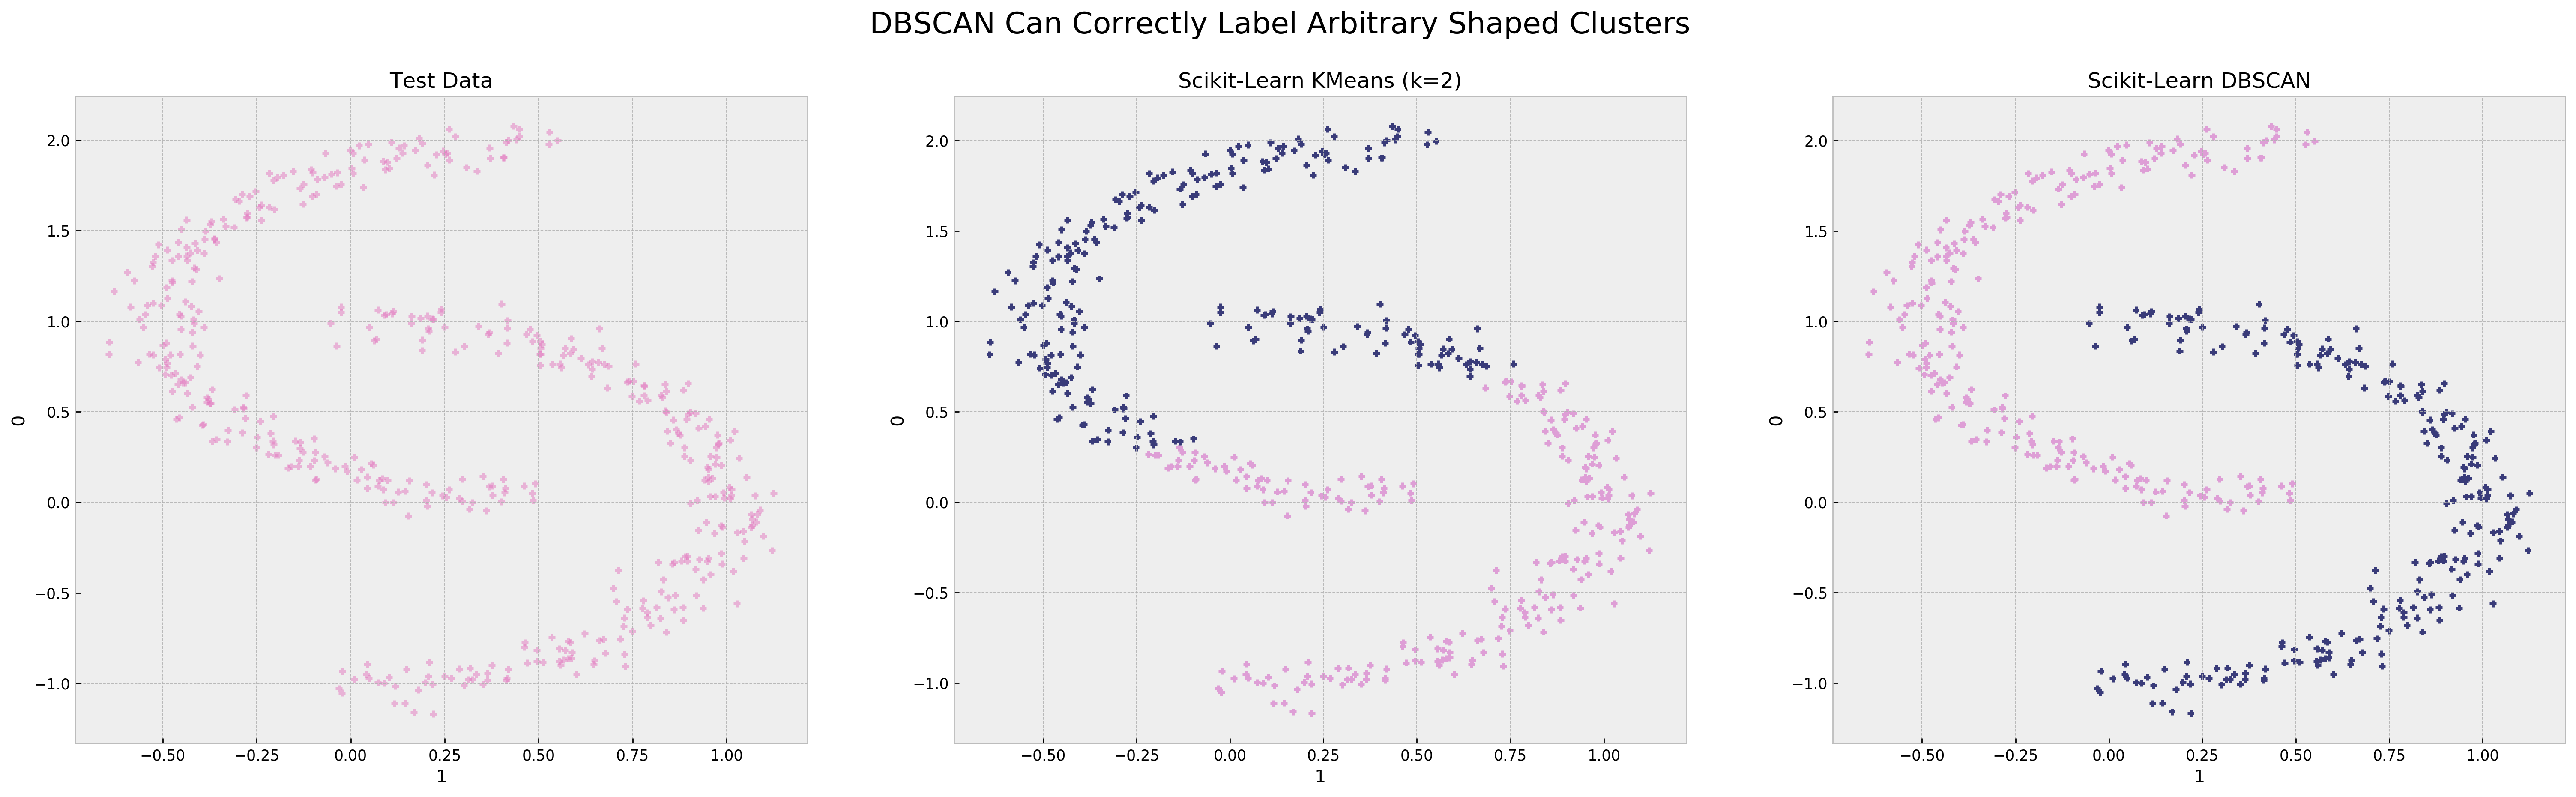

In [2]:
# Create Blobs
blobs = make_moons(500, noise=0.06)[0]

#Plot
plt.style.use("bmh")
fig, ax = plt.subplots(1,3, dpi=250)
fig.suptitle("DBSCAN Can Correctly Label Arbitrary Shaped Clusters", fontsize=20)

# Scikit-Learn KMeans
preds_k = KMeans(2).fit(blobs).labels_
kmean_blob = np.append(blobs, preds_k.reshape(-1,1), axis=1)
pd.DataFrame(kmean_blob).plot(x=1, y=0, kind="scatter",ax=ax[1], c=2, colorbar=False, title= "Scikit-Learn KMeans (k=2)", marker="+", colormap="tab20b")

# Scikit-Learn DBSCAN
preds = dbscan(blobs, 0.2, 5)[1]
dbscan_blob = np.append(blobs, preds.reshape(-1,1), axis=1)
pd.DataFrame(dbscan_blob).plot(x=1, y=0, kind="scatter", c=2, colorbar=False, ax=ax[2], title= "Scikit-Learn DBSCAN", marker="+", colormap="tab20b")

# Test Data
pd.DataFrame(blobs).plot(x=1, y=0, kind="scatter", ax=ax[0], alpha=0.5, figsize=(30,8), title="Test Data", marker="+", c="#e377c0")

fig.savefig("subplots1.png", dpi=250)
plt.show()

In [3]:
class dbscan2():
    def __init__(self,df, epsilon=1, min_points=5):
        self.df = np.array(df)
        self.epsilon = epsilon
        self.min_points = min_points
        self.cluster_label = 0
        self.noise = 0
        
    def fit(self):
        "Fit the data"
        
        # Create labels column initialized to -1 (unclassified)
        self.df = np.append(self.df, np.array([[-1]*len(blobs)]).reshape(-1,1), axis=1)
        
        for x in range(len(self.df)):
            
            # if the point is not labled already then search for neighbors
            if self.df[x,2] != -1:
                continue
            
            # find neighbors
            p = self.df[x,:2]
            neighbors = self.rangeQuery(p)
            
            # If less neighbors than min_points then label as noise and continue
            if len(neighbors) < self.min_points:
                self.df[x,2] = self.noise
                continue
                
            # increment cluster label
            self.cluster_label += 1

            # set current row to new cluster label
            self.df[x,2] = self.cluster_label

            # create seed set to hold all neighbors of cluster including the neighbors already found
            found_neighbors = neighbors
            
            # create Queue to fold all neighbors of cluster
            q = Queue()
            
            # add original neighbors
            for x in neighbors:
                q.put(x)
            
            # While isnt empty label new neighbors to cluster
            while q.empty() == False:
                
                current = q.get()
                
                # if cur_row labled noise then change to cluster label (border point)
                if self.df[current,2] == 0:
                    self.df[current,2] = self.cluster_label

                # If label is not -1(unclassified) then continue
                if self.df[current,2] != -1:
                    continue
                    
                # label the neighbor
                self.df[current,2] = self.cluster_label

                # look for neightbors of cur_row
                point = self.df[current,:2]
                neighbors2 = self.rangeQuery(point)
                
                # if neighbors2 >= min_points then add those neighbors to seed_set
                if len(neighbors2) >= self.min_points:

                    for x in neighbors2:
                        if x not in found_neighbors:
                            q.put(x)
                            found_neighbors.append(x)                           
    
    def predict(self, x):
        "Return the predicted labels"
        
        preds = []
        
        for point in x:
            neighbors = self.rangeQuery(point)
            label = self.df[neighbors[0],2]
            preds.append(label)
        
        return preds
    
    def rangeQuery(self, x):
        """Query database against x and return all points that are <= epsilon"""
        
        neighbors = []
        
        for y in range(len(self.df)):
            q = self.df[y, :2]
            if self.dist(x, q) <= self.epsilon:
                neighbors.append(y)
        
        return neighbors
    
    def dist(self, point1, point2):
        """Euclid distance function"""
        
        x1 = point1[0]
        x2 = point2[0]
        y1 = point1[1]
        y2 = point2[1]
        
        # create the points 
        p1 = (x1 - x2)**2
        p2 = (y1 - y2)**2

        return np.sqrt(p1 + p2)

test = dbscan2(blobs, 0.2, 5)
test.fit()

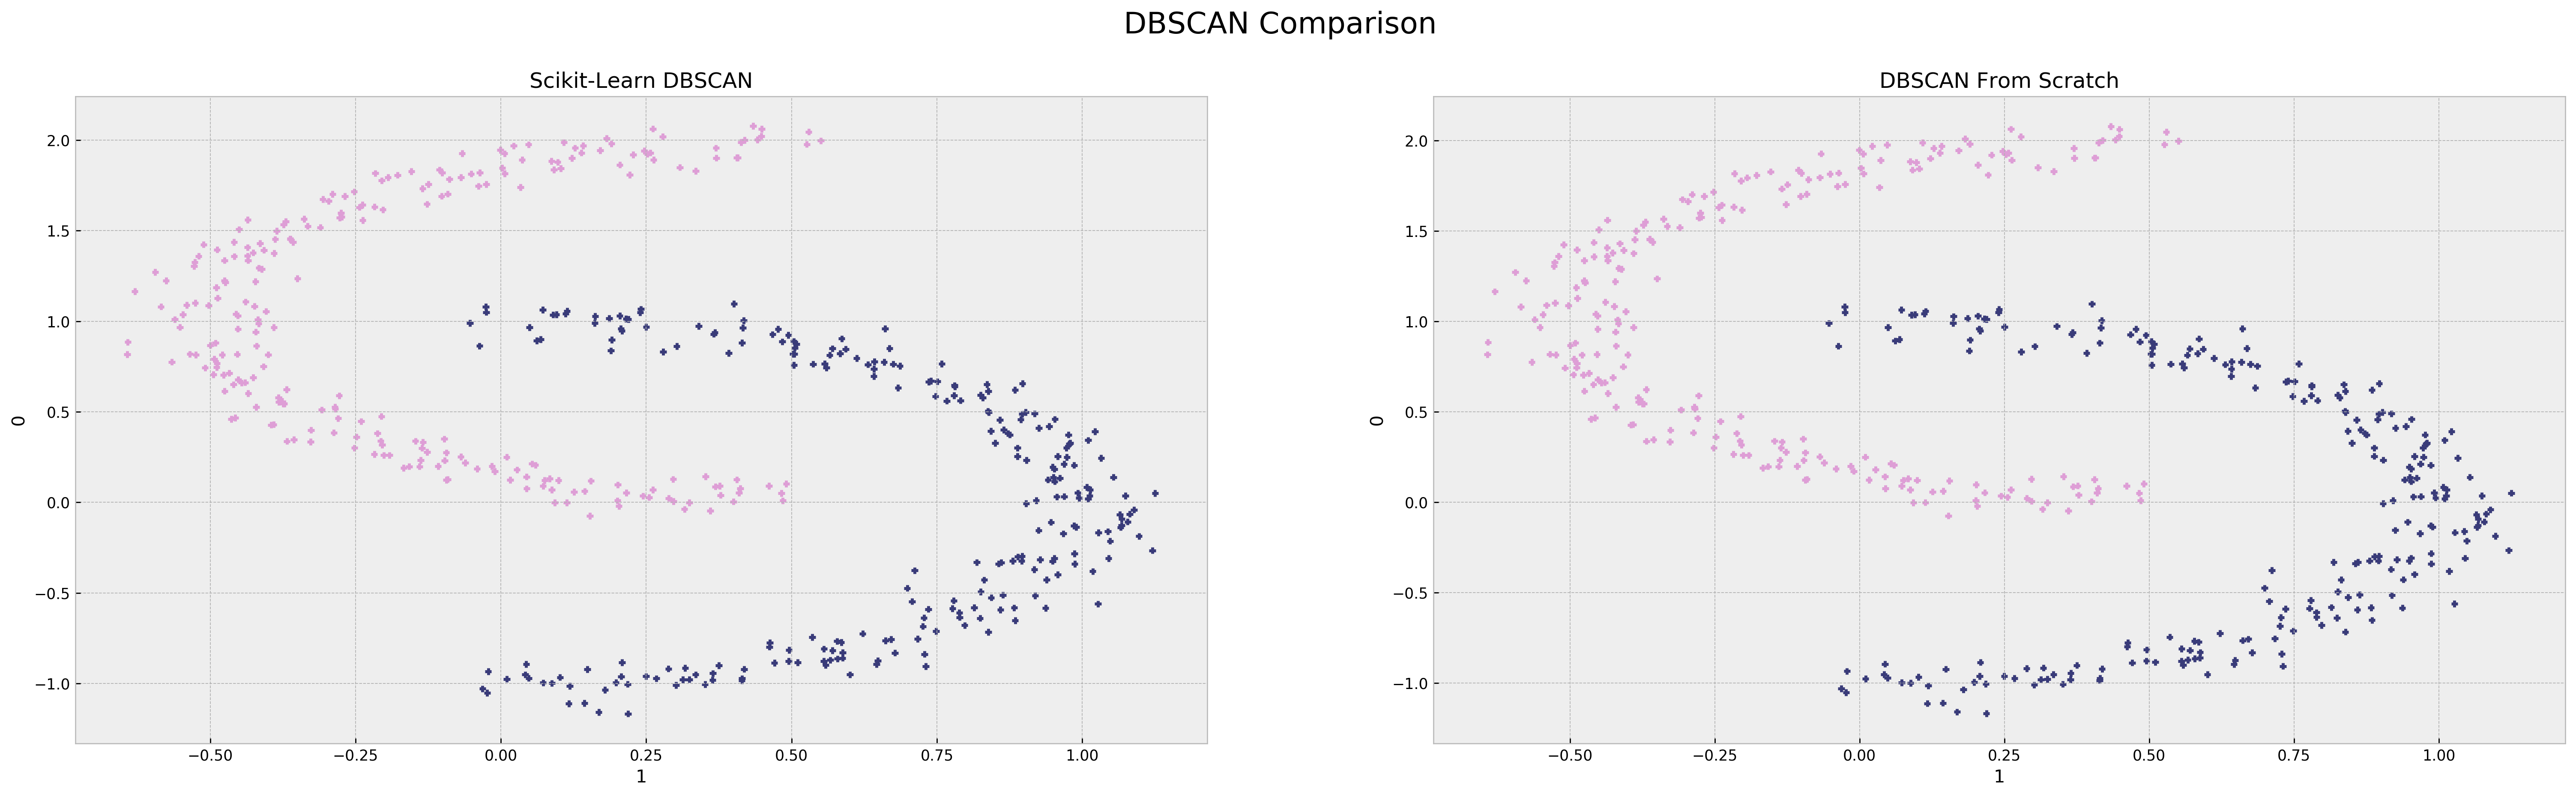

In [4]:
#Plot
plt.style.use("bmh")
fig, ax = plt.subplots(1,2, dpi=250)
fig.suptitle("DBSCAN Comparison", fontsize=20)

pd.DataFrame(test.df).plot(x=1, y=0, kind="scatter",ax=ax[1], c=2, colorbar=False, title= "DBSCAN From Scratch", marker="+", colormap="tab20b")
pd.DataFrame(dbscan_blob).plot(x=1, y=0, kind="scatter",ax=ax[0], c=2, colorbar=False, title= "Scikit-Learn DBSCAN", marker="+", colormap="tab20b", figsize=(30,8))

fig.savefig("subplots4.png", dpi=250)
plt.show()

In [8]:
# Create Blobs
blobs = make_moons(500, noise=0.06)[0]

In [7]:
%%time
%%capture
dbscan(blobs, 0.2, 5)

CPU times: user 7.97 ms, sys: 1.33 ms, total: 9.3 ms
Wall time: 8.21 ms


In [8]:
%%time
%%capture
dbscan2(blobs, 0.2, 5).fit()

CPU times: user 980 ms, sys: 11.4 ms, total: 992 ms
Wall time: 999 ms
